<a href="https://colab.research.google.com/github/AnnaGass/DSA-SleepHealthData/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select the subject to be used

In [1]:
subject = '013'

# Import the data from physionet

In [2]:
import subprocess

rec_path = "https://physionet.org/files/ucddb/1.0.0/ucddb" + subject + ".rec"
annotation_path = "https://physionet.org/files/ucddb/1.0.0/ucddb0" + subject + "_stage.txt"

command = "wget -r -N -c -np " + rec_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

command = "wget -r -N -c -np " + annotation_path
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Install needed libraries

In [3]:
!pip install pyedflib
!pip install pandas

# Prepare the data

In [4]:
import pyedflib
import csv
import os
from datetime import timedelta

spo2_index = 6      # taken from the headers
pulse_index = 13    # taken from the headers

# Initialize an empty list to store your values
data = []

# open the file
path = "/content/physionet.org/files/ucddb/1.0.0/ucddb" + subject + ".rec"
f = pyedflib.EdfReader(path)

# file properties
start_time = f.getStartdatetime()
file_duration = f.getFileDuration()
signal_labels = f.getSignalLabels()

# SpO2 information
spo2_header = f.getSignalHeader(spo2_index)
spo2_signals = f.readSignal(spo2_index)

# Pulse information
pulse_header = f.getSignalHeader(pulse_index)
pulse_signals = f.readSignal(pulse_index)

# Calculate frequency
time_between_meassurements = file_duration / len(pulse_signals)

# Iterate and add the increment to the datetime on each iteration
for i in range(len(pulse_signals)):
    data.append([start_time, spo2_signals[i], pulse_signals[i]])
    start_time += timedelta(seconds=time_between_meassurements)

# Specify the file name
csv_file = "results/subject" + subject + ".csv"

# Create results folder if not exists
if not os.path.exists("results"):
    # Create the folder
    os.makedirs("results")

# Write the data to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

f.close()

# Plot the csv

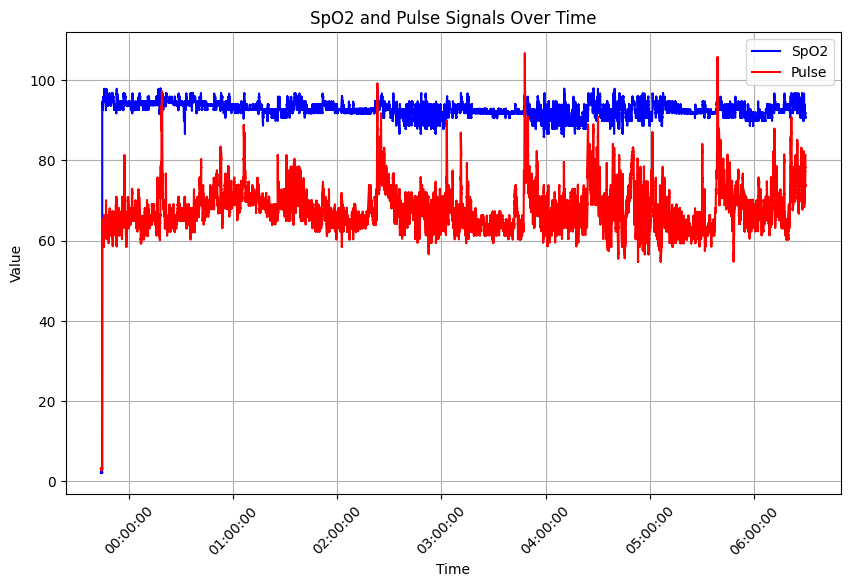

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Load CSV data into a DataFrame assuming the order of columns is timestamp, spo2, and pulse
df = pd.read_csv(csv_file, header=None)

# Assuming the columns are in order: timestamp, spo2, and pulse
timestamp = df.iloc[:, 0]
spo2 = df.iloc[:, 1]
pulse = df.iloc[:, 2]

# Parse each datetime string into a datetime object
datetime_objects = []
for dt_str in timestamp:
    try:
        # Try parsing with milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f")
    except ValueError:
        # If milliseconds are not present, parse without milliseconds
        dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    datetime_objects.append(dt_obj)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(datetime_objects, spo2, label='SpO2', color='blue')
plt.plot(datetime_objects, pulse, label='Pulse', color='red')

plt.title('SpO2 and Pulse Signals Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Set the format of the x-axis ticks to display only the time part
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plot_png = "results/subject_plot" + subject + ".png"

# Save the plot to a file
plt.savefig(plot_png)

# Show the plot
plt.show()
